In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from scipy.sparse import hstack

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import pickle
import tqdm

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

from wordcloud import WordCloud, STOPWORDS 

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('preprocessed_data.csv', nrows=50000)

In [3]:
data.shape

(50000, 9)

### Spliting X and Y

In [4]:
y = data.project_is_approved
X = data.drop(["project_is_approved"], axis=1)

### Spliting Train, Test and Cross Validation datasets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, stratify=y)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

### Defing one hot encoding functions

In [6]:
def convert_text_into_TFIDF(feature):
    '''This function transforms a feature into TFIDF vector'''
    
    vectorizer = TfidfVectorizer(min_df = 10, ngram_range=(1,4), max_features=5000)
    vectorizer.fit(X_train[feature].values)
    
    X_train_ohe = vectorizer.transform(X_train[feature].values)
    X_test_ohe = vectorizer.transform(X_test[feature].values)
    #X_cv_ohe = vectorizer.transform(X_cv[feature].values)
    
    return vectorizer, X_train_ohe, X_test_ohe #,X_cv_ohe

In [7]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

def calculate_TFIDF_Weighted_W2V(feature_value, dictionary, tfidf_words):   
    
    
    tfidf_w2v_vectors = []
    
    for sentence in feature_value:
        vector = np.zeros(300)
        tf_idf_weight = 0
        
        for word in sentence.split():
            if(word in tfidf_words) and (word in glove_words):
                vec = model[word] 
                
                tf_idf = dictionary[word] * (sentence.count(word)/len(sentence.split()))
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
        
    return tfidf_w2v_vectors    

def convert_Text_Into_TFIDF_Weighted_W2V(feature):
    
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(X_train[feature].values)
    
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    
    X_train_tfidf_w2v = calculate_TFIDF_Weighted_W2V(X_train[feature].values, dictionary, tfidf_words)
    #X_cv_tfidf_w2v = calculate_TFIDF_Weighted_W2V(X_cv[feature].values)
    X_test_tfidf_w2v = calculate_TFIDF_Weighted_W2V(X_test[feature].values, dictionary, tfidf_words)
    
    return tfidf_model, X_train_tfidf_w2v, X_test_tfidf_w2v #, X_cv_tfidf_w2v

In [8]:
def convert_categorical_Into_BOW(feature):
    
    vectorizer = CountVectorizer(binary=True)
    vectorizer.fit(X_train[feature].values)
    
    X_train_ohe = vectorizer.transform(X_train[feature].values)
    #X_cv_ohe = vectorizer.transform(X_cv[feature].values)
    X_test_ohe = vectorizer.transform(X_test[feature].values)
    
    return vectorizer, X_train_ohe, X_test_ohe #, X_cv_ohe

In [9]:
def encode_numerical_features(feature):
    
    normalizer = Normalizer()
    normalizer.fit(X_train[feature].values.reshape(1,-1))
    
    X_train_ohe = normalizer.transform(X_train[feature].values.reshape(1,-1))
    #X_cv_ohe = normalizer.transform(X_cv[feature].values.reshape(1,-1))
    X_test_ohe = normalizer.transform(X_test[feature].values.reshape(1,-1))
    
    return normalizer, X_train_ohe.reshape(-1,1), X_test_ohe.reshape(-1,1)#, X_cv_ohe.reshape(-1,1)

In [10]:
'''
#Categorical
X_train['school_state']
X_train['teacher_prefix']
X_train['project_grade_category']
X_train['clean_categories']
X_train['clean_subcategories']

#numerical
X_train['teacher_number_of_previously_posted_projects']
X_train['price']

#essay
X_train['essay']'''

"\n#Categorical\nX_train['school_state']\nX_train['teacher_prefix']\nX_train['project_grade_category']\nX_train['clean_categories']\nX_train['clean_subcategories']\n\n#numerical\nX_train['teacher_number_of_previously_posted_projects']\nX_train['price']\n\n#essay\nX_train['essay']"

### Applying One hot encoding on categorical features

In [11]:
#Permoring One hot encoding for School State
vectorizer_state, X_train_state, X_test_state = convert_categorical_Into_BOW('school_state')
lst_state_features = vectorizer_state.get_feature_names()

#Permoring One hot encoding for tech_prefix
vectorizer_tchr_prfx, X_train_tchr_prfx, X_test_tchr_prfx = convert_categorical_Into_BOW('teacher_prefix')
lst_tchr_prfx_features = vectorizer_tchr_prfx.get_feature_names()

#Permoring One hot encoding for grade_category
vectorizer_grade, X_train_grade, X_test_grade = convert_categorical_Into_BOW('project_grade_category')
lst_grade_features = vectorizer_grade.get_feature_names()

#Permoring One hot encoding for categories
vectorizer_categories, X_train_categories, X_test_categories = convert_categorical_Into_BOW('clean_categories')
lst_categories_features = vectorizer_categories.get_feature_names()

#Permoring One hot encoding for subcategories
vectorizer_subcategories, X_train_subcategories, X_test_subcategories \
                                = convert_categorical_Into_BOW('clean_subcategories')
lst_subcategories_features = vectorizer_subcategories.get_feature_names()

In [12]:
X_train_categories.shape

(33500, 9)

### Applying Normalizing on numerical features

In [13]:
#Permoring normalization on teacher_number_of_previously_posted_projects
normalizer_prev_projects, X_train_prev_projects, X_test_prev_projects \
                        = encode_numerical_features('teacher_number_of_previously_posted_projects')
    
#Permoring normalization on price
normalizer_price, X_train_price, X_test_price = encode_numerical_features('price')

### Applying One hot encoding on textual features (TFIDF)

In [14]:
#Performing TFIDF feature vectoriztion on essay
tfdif_vectorizer_essay, X_train_essay_tfidf, X_test_essay_tfidf = convert_text_into_TFIDF('essay')

### Applying One hot encoding on textual features (TFIDF Word2Vec)

In [15]:
#Performing TFIDF word2vec feature vectoriztion on essay
w2v_vectorizer_essay, X_train_essay_w2v, X_test_essay_w2v = convert_Text_Into_TFIDF_Weighted_W2V('essay')

### Concatenating all features

In [16]:
#Concatinating feature set 1(TFIDF)
X_tr_set1 = hstack((X_train_state, X_train_tchr_prfx, X_train_grade, X_train_categories, X_train_subcategories,
                   X_train_prev_projects, X_train_price, X_train_essay_tfidf)).tocsr()

#X_cv_set1 = hstack((X_cv_state, X_cv_tchr_prfx, X_cv_grade, X_cv_categories, X_cv_subcategories,
#                   X_cv_prev_projects, X_cv_price, X_cv_essay_tfidf)).tocsr()

X_te_set1 = hstack((X_test_state, X_test_tchr_prfx, X_test_grade, X_test_categories, X_test_subcategories,
                   X_test_prev_projects, X_test_price, X_test_essay_tfidf)).tocsr()

In [17]:
#Concatinating feature set 1(TFIDF Word2Vec)
X_tr_set2 = hstack((X_train_state, X_train_tchr_prfx, X_train_grade, X_train_categories, X_train_subcategories,
                   X_train_prev_projects, X_train_price, X_train_essay_w2v)).tocsr()

#X_cv_set2 = hstack((X_cv_state, X_cv_tchr_prfx, X_cv_grade, X_cv_categories, X_cv_subcategories,
#                   X_cv_prev_projects, X_cv_price, X_cv_essay_tfidf)).tocsr()

X_te_set2 = hstack((X_test_state, X_test_tchr_prfx, X_test_grade, X_test_categories, X_test_subcategories,
                   X_test_prev_projects, X_test_price, X_test_essay_w2v)).tocsr()

In [18]:
class CV_Results:    
    def __init__(self, depth, split, acc_score):
        self.depth = depth
        self.split = split
        self.acc_score = acc_score

In [19]:
def getTrain_and_Cv_scores(grid_search):

    lst_train_scores = []
    lst_cv_scores = []


    idx_score = 0
    for i, depth in enumerate(depth_range):
        for j, min_split in enumerate(min_split_sample_range):

            train_scores = []
            cv_scores = []

            for k in range(n_folds):
                k_fold_train_score = grid_search.cv_results_['split' + str(k) +'_train_score'][idx_score]
                k_fold_cv_score = grid_search.cv_results_['split' + str(k) +'_test_score'][idx_score]

                train_scores.append(k_fold_train_score)
                cv_scores.append(k_fold_cv_score)

            idx_score += 1

            #print(np.mean(np.array(train_scores)))
            #print(np.mean(np.array(cv_scores)))
            train_result = CV_Results(depth, min_split, np.mean(np.array(train_scores)))
            cv_result = CV_Results(depth, min_split, np.mean(np.array(cv_scores)))

            lst_train_scores.append(train_result)
            lst_cv_scores.append(cv_result)
            
    return lst_train_scores, lst_cv_scores

In [20]:
def print_train_cv_score(lst_train_scores, lst_cv_scores):
    print('\n---------Train scores----------')
    for scores in lst_train_scores:
        print(f'Depth :{scores.depth} Split :{scores.split} Auc score:{scores.acc_score}')


    print('\n---------CV scores----------')
    for scores in lst_cv_scores:
        print(f'Depth :{scores.depth} Split :{scores.split} Auc score:{scores.acc_score}')

In [21]:
def plot3DGraph(lst_train_scores, lst_cv_scores):
    
    train_scores = [x.acc_score for x in lst_train_scores]
    train_scores = np.array(train_scores).reshape(len(depth_range), len(min_split_sample_range))
    
    cv_scores = [x.acc_score for x in lst_cv_scores]
    cv_scores = np.array(cv_scores).reshape(len(depth_range), len(min_split_sample_range))
    
    # https://plot.ly/python/3d-axes/
    for i in range(len(train_scores)):
        trace1 = go.Scatter3d(x=min_split_sample_range, y=depth_range, z=train_scores[i], name = 'Train')
        trace2 = go.Scatter3d(x=min_split_sample_range, y=depth_range, z=cv_scores[i], name = 'Cross Validation')
        data = [trace1, trace2]

        layout = go.Layout(scene = dict(
                xaxis = dict(title='Splits'),
                yaxis = dict(title='Max Depth'),
                zaxis = dict(title='Auc score'),))

        fig = go.Figure(data=data, layout=layout)
        offline.iplot(fig, filename='3d-scatter-colorscale')

In [22]:
def plot_AUC(train_fpr, train_tpr, test_fpr, test_tpr, train_auc, test_auc, title):
    '''This function plot AUC curve for both train and test FPR and TPR'''
    
    plt.plot(train_fpr, train_tpr, label= f"Train AUC = {train_auc}" )
    plt.plot(test_fpr, test_tpr, label = f"Test AUC = {test_auc}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")    
    plt.title(title)
    
    plt.grid()
    plt.show()

In [23]:
def create_wordcloud_using_fp_essay(X_test_fp_essay):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in X_test_fp_essay: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

In [24]:
def plot_Box_plot(X_te_fp_price):
    sns.boxplot(data= X_te_fp_price)
    plt.xlabel("Price")
    plt.ylabel("Percentiles")
    plt.title("Price vs Likelihood of more datapoints")
    plt.show()

In [25]:
def plot_PDF(X_test_fp_tchr_prfx):
    counts, bin_edges = np.histogram(X_test_fp_tchr_prfx, bins=5, density=True)

    pdf = counts/sum(counts)
    plt.close()
    plt.plot(bin_edges[1:], pdf)

    plt.xlabel("Bins")
    plt.ylabel("Likelihood of price")
    plt.title("PDF plot")
    plt.grid()
    plt.show();

### Train model with Train set 1

In [26]:
depth_range = [1, 5, 10, 50]
min_split_sample_range = [5, 10, 100, 500]


param = {'max_depth': depth_range, 'min_samples_split': min_split_sample_range}
n_folds = 3

clf = DecisionTreeClassifier()

#Finding best alpha using GridSearchCV method
clf_set1 = GridSearchCV(estimator = clf, param_grid= param, cv=n_folds, scoring='roc_auc')
clf_set1.fit(X_tr_set1, y_train)

clf_set1.best_params_

{'max_depth': 10, 'min_samples_split': 500}

### Getting Train and CV Scores for set 1

In [38]:
lst_train_scores_set1, lst_cv_scores_set1 = getTrain_and_Cv_scores(clf_set1)

### Printing Train and CV Scores for set 1

In [28]:
print_train_cv_score(lst_train_scores_set1, lst_cv_scores_set1)


---------Train scores----------
Depth :1 Split :5 Auc score:0.5507491124365663
Depth :1 Split :10 Auc score:0.5507491124365663
Depth :1 Split :100 Auc score:0.5507491124365663
Depth :1 Split :500 Auc score:0.5507491124365663
Depth :5 Split :5 Auc score:0.6465945047926129
Depth :5 Split :10 Auc score:0.646479201024828
Depth :5 Split :100 Auc score:0.6463301649755835
Depth :5 Split :500 Auc score:0.6450873114942728
Depth :10 Split :5 Auc score:0.7126791345239473
Depth :10 Split :10 Auc score:0.7108170536055335
Depth :10 Split :100 Auc score:0.70099833037093
Depth :10 Split :500 Auc score:0.6911316159665092
Depth :50 Split :5 Auc score:0.9303623500195389
Depth :50 Split :10 Auc score:0.9232402394456144
Depth :50 Split :100 Auc score:0.8881756410849477
Depth :50 Split :500 Auc score:0.846540392197392

---------CV scores----------
Depth :1 Split :5 Auc score:0.547806551314273
Depth :1 Split :10 Auc score:0.547806551314273
Depth :1 Split :100 Auc score:0.547806551314273
Depth :1 Split :500 

### Plotting 3D graph for Train and CV Scores for set 1

In [28]:
plot3DGraph(lst_train_scores_set1, lst_cv_scores_set1)

### Training model with best parameter set 1

In [29]:
decision_tree_clf_set1 = DecisionTreeClassifier(max_depth= clf_set1.best_params_['max_depth'], 
                                                min_samples_split= clf_set1.best_params_['min_samples_split'])

decision_tree_clf_set1.fit(X_tr_set1, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Finding AUC curve on train and test data for set 1

In [30]:
y_train_proba_set1 = decision_tree_clf_set1.predict_proba(X_tr_set1)[:,1]
y_test_proba_set1 = decision_tree_clf_set1.predict_proba(X_te_set1)[:,1]


#Finding AUC on train and test data
train_auc_set1 = roc_auc_score(y_train, y_train_proba_set1)
print('Train Auc for set 1')
print(train_auc_set1)

test_auc_set1 = roc_auc_score(y_test, y_test_proba_set1)
print('\n Test Auc for set 1')
print(test_auc_set1)

Train Auc for set 1
0.6819281751494053

 Test Auc for set 1
0.6382660714947075


### Plotting ROC curve of train and test data for set 1

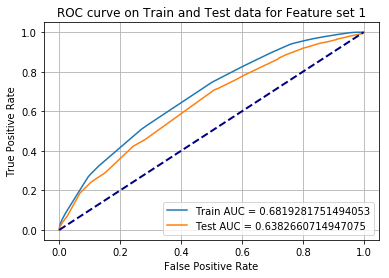

In [31]:


#Finding FPR and TPR both on train and test
train_fpr_set1, train_tpr_set1, train_threshold_set1 = roc_curve(y_train, y_train_proba_set1)
test_fpr_set1, test_tpr_set1, test_threshold_set1 = roc_curve(y_test, y_test_proba_set1)

#Plotting AUC curve
plot_AUC(train_fpr_set1, train_tpr_set1, test_fpr_set1, test_tpr_set1, train_auc_set1, test_auc_set1,
         'ROC curve on Train and Test data for Feature set 1')

### Plotting confusion matrix for set 1

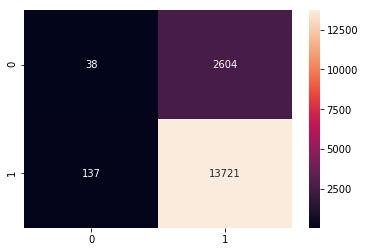

In [32]:
#Predicting y_test
y_test_pred_set1 = decision_tree_clf_set1.predict(X_te_set1)

confusion_matrix_set1 = confusion_matrix(y_test, y_test_pred_set1)

#Seaborn Heatmap representaion of Train confusion matrix
sns.heatmap(confusion_matrix_set1, annot=True, fmt="d")

In [33]:
#Extracting False positive datapoints

fp_indices = []
for i in range(len(y_test)):
    if (np.array(y_test)[i] == 0) & (y_test_pred_set1[i] == 1):
        fp_indices.append(i)

### Exploratory Data analysis for set 1

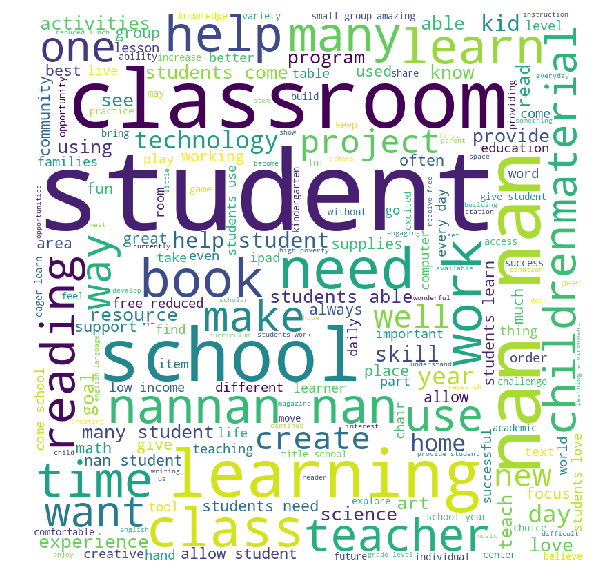

In [34]:
#Creating wordcloud from false positive data points of feature essay
X_test_fp_set1 = X_test['essay'][fp_indices]

create_wordcloud_using_fp_essay(X_test_fp_set1)

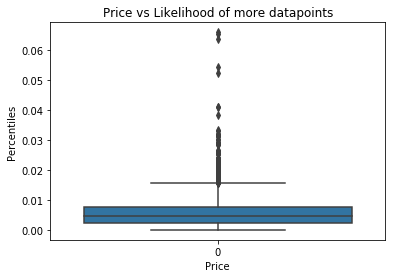

In [35]:
#Extracting price feature and plotting Box plot
plot_Box_plot(X_test_price[fp_indices])

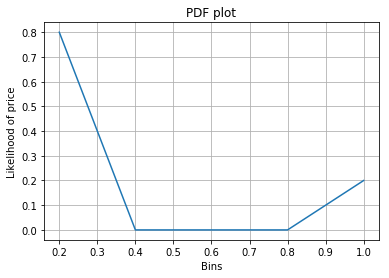

In [36]:
#Extracting teacher_number_of_previously_posted_projects feature and plotting PDF
plot_PDF(np.array(X_test_tchr_prfx[fp_indices].toarray()))

### Train model with Train set 2

In [37]:
clf = DecisionTreeClassifier()

#Finding best alpha using GridSearchCV method
clf_set2 = GridSearchCV(estimator = clf, param_grid= param, cv=n_folds, scoring='roc_auc')
clf_set2.fit(X_tr_set2, y_train)

clf_set2.best_params_

{'max_depth': 5, 'min_samples_split': 100}

### Getting Train and CV Scores for set 2

In [38]:
lst_train_scores_set2, lst_cv_scores_set2 = getTrain_and_Cv_scores(clf_set2)

### Printing Train and CV Scores for set 2

In [39]:
print_train_cv_score(lst_train_scores_set2, lst_cv_scores_set2)


---------Train scores----------
Depth :1 Split :5 Auc score:0.5656283076900581
Depth :1 Split :10 Auc score:0.5656283076900581
Depth :1 Split :100 Auc score:0.5656283076900581
Depth :1 Split :500 Auc score:0.5656283076900581
Depth :5 Split :5 Auc score:0.6698781215762777
Depth :5 Split :10 Auc score:0.6698427066102849
Depth :5 Split :100 Auc score:0.6691677458385742
Depth :5 Split :500 Auc score:0.6686451553525025
Depth :10 Split :5 Auc score:0.7991388945323764
Depth :10 Split :10 Auc score:0.7965143365257044
Depth :10 Split :100 Auc score:0.7664123435750279
Depth :10 Split :500 Auc score:0.7275243394428368
Depth :50 Split :5 Auc score:0.9995009257421777
Depth :50 Split :10 Auc score:0.9959053716803791
Depth :50 Split :100 Auc score:0.9241688525988927
Depth :50 Split :500 Auc score:0.7802882699803738

---------CV scores----------
Depth :1 Split :5 Auc score:0.564942753052913
Depth :1 Split :10 Auc score:0.564942753052913
Depth :1 Split :100 Auc score:0.564942753052913
Depth :1 Split :

### Plotting 3D graph for Train and CV Scores for set 2

In [40]:
plot3DGraph(lst_train_scores_set2, lst_cv_scores_set2)

### Training model with best parameter set 2

In [41]:
decision_tree_clf_set2 = DecisionTreeClassifier(max_depth= clf_set2.best_params_['max_depth'], 
                                                min_samples_split= clf_set2.best_params_['min_samples_split'])

decision_tree_clf_set2.fit(X_tr_set2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Finding AUC curve on train and test data for set 2

In [42]:
y_train_proba_set2 = decision_tree_clf_set2.predict_proba(X_tr_set2)[:,1]
y_test_proba_set2 = decision_tree_clf_set2.predict_proba(X_te_set2)[:,1]


#Finding AUC on train and test data
train_auc_set2 = roc_auc_score(y_train, y_train_proba_set2)
print('Train Auc for set 2')
print(train_auc_set2)

test_auc_set2 = roc_auc_score(y_test, y_test_proba_set2)
print('\n Test Auc for set 2')
print(test_auc_set2)

Train Auc for set 2
0.6682739176427857

 Test Auc for set 2
0.6270552081789021


### Plotting ROC curve of train and test data for set 2

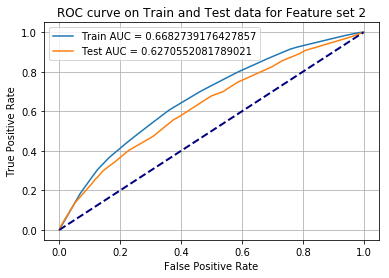

In [43]:
#Finding FPR and TPR both on train and test
train_fpr_set2, train_tpr_set2, train_threshold_set2 = roc_curve(y_train, y_train_proba_set2)
test_fpr_set2, test_tpr_set2, test_threshold_set2 = roc_curve(y_test, y_test_proba_set2)

#Plotting AUC curve
plot_AUC(train_fpr_set2, train_tpr_set2, test_fpr_set2, test_tpr_set2, train_auc_set2, test_auc_set2,
         'ROC curve on Train and Test data for Feature set 2')

### Plotting confusion matrix for set 2

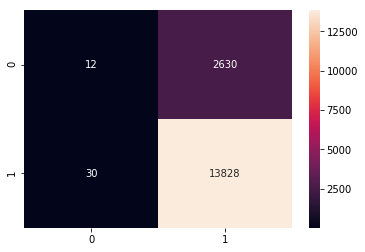

In [44]:
#Predicting y_test
y_test_pred_set2 = decision_tree_clf_set2.predict(X_te_set2)

confusion_matrix_set2 = confusion_matrix(y_test, y_test_pred_set2)

#Seaborn Heatmap representaion of Train confusion matrix
sns.heatmap(confusion_matrix_set2, annot=True, fmt="d")

In [45]:
#Extracting False positive datapoints

fp_indices = []
for i in range(len(y_test)):
    if (np.array(y_test)[i] == 0) & (y_test_pred_set2[i] == 1):
        fp_indices.append(i)

### Exploratory Data analysis for set 2

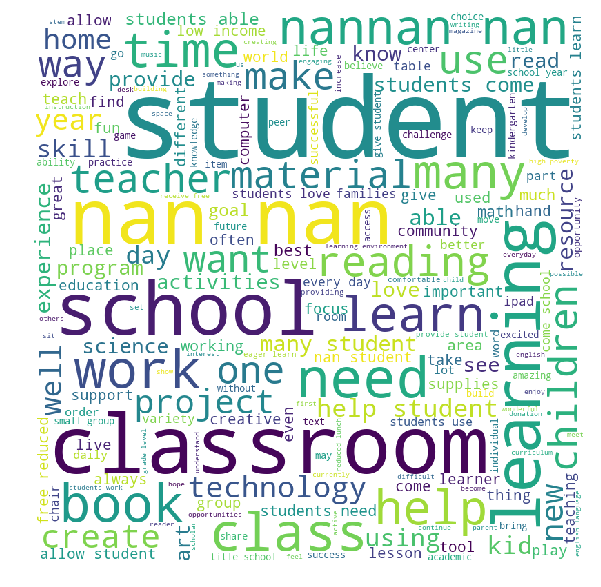

In [46]:
#Creating wordcloud from false positive data points of feature essay
X_test_fp_set2 = X_test['essay'][fp_indices]

create_wordcloud_using_fp_essay(X_test_fp_set2)

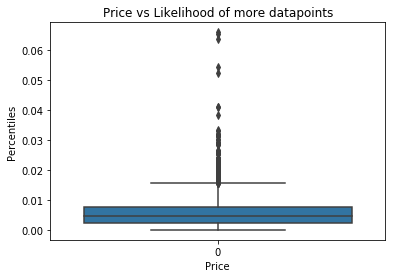

In [47]:
#Extracting price feature and plotting Box plot
plot_Box_plot(X_test_price[fp_indices])

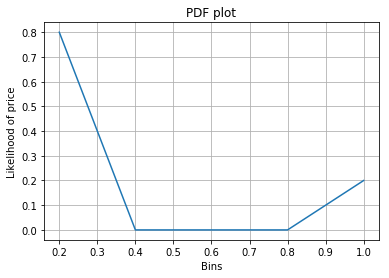

In [48]:
#Extracting teacher_number_of_previously_posted_projects feature and plotting PDF
plot_PDF(np.array(X_test_tchr_prfx[fp_indices].toarray()))

# Task 2

### Training model with dataset 1 with max_depth as None to get feature_importances

In [49]:
task2_clf_set1 = DecisionTreeClassifier(min_samples_split= clf_set1.best_params_['min_samples_split'])

task2_clf_set1.fit(X_tr_set1, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [50]:
#Extracting nonZero features
nonzero_features = np.nonzero(task2_clf_set1.feature_importances_)[0]
print(nonzero_features)

[  26   46   64 ... 5083 5088 5094]


### Training model with dataset 1 by discarding the nonzero features

In [51]:
from sklearn.linear_model import LogisticRegression

X_tr_nonzero_set1 = X_tr_set1[:, nonzero_features]
X_te_nonzero_set1 = X_te_set1[:, nonzero_features]

param = {'C': [0.001, 1, 100]}

clf_LR = LogisticRegression()

grid_search = GridSearchCV(clf_LR, param_grid = param)
grid_search.fit(X_tr_nonzero_set1, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 1, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [52]:
grid_search.best_params_

{'C': 0.001}

### Training model with best parameter set 1

In [53]:
LR_clf_set1 = LogisticRegression(C= grid_search.best_params_['C'])

LR_clf_set1.fit(X_tr_nonzero_set1, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Finding AUC curve on train and test data for set 1

In [54]:
y_train_proba_set1 = LR_clf_set1.predict_proba(X_tr_nonzero_set1)[:,1]
y_test_proba_set1 = LR_clf_set1.predict_proba(X_te_nonzero_set1)[:,1]


#Finding AUC on train and test data
LR_train_auc_set1 = roc_auc_score(y_train, y_train_proba_set1)
print('Train Auc for set 1')
print(LR_train_auc_set1)

LR_test_auc_set1 = roc_auc_score(y_test, y_test_proba_set1)
print('\n Test Auc for set 1')
print(LR_test_auc_set1)

Train Auc for set 1
0.5720915251671519

 Test Auc for set 1
0.5750185809151741


### Plotting ROC curve of train and test data for set 1

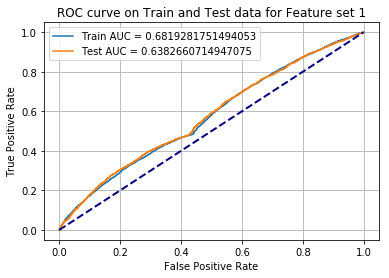

In [55]:
#Finding FPR and TPR both on train and test
train_fpr_set1, train_tpr_set1, train_threshold_set1 = roc_curve(y_train, y_train_proba_set1)
test_fpr_set1, test_tpr_set1, test_threshold_set1 = roc_curve(y_test, y_test_proba_set1)

#Plotting AUC curve
plot_AUC(train_fpr_set1, train_tpr_set1, test_fpr_set1, test_tpr_set1, train_auc_set1, test_auc_set1,
         'ROC curve on Train and Test data for Feature set 1')

### Plotting confusion matrix for set 1

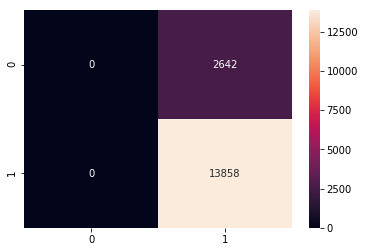

In [56]:
#Predicting y_test
y_test_pred_set1 = LR_clf_set1.predict(X_te_nonzero_set1)

confusion_matrix_set1 = confusion_matrix(y_test, y_test_pred_set1)

#Seaborn Heatmap representaion of Train confusion matrix
sns.heatmap(confusion_matrix_set1, annot=True, fmt="d")

In [57]:
#Extracting False positive datapoints

fp_indices = []
for i in range(len(y_test)):
    if (np.array(y_test)[i] == 0) & (y_test_pred_set1[i] == 1):
        fp_indices.append(i)

### Exploratory Data analysis for set 1

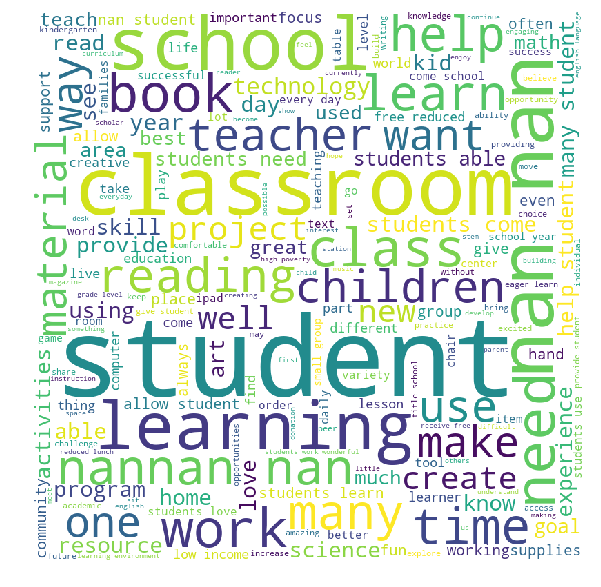

In [58]:
#Creating wordcloud from false positive data points of feature essay
X_test_fp_set1 = X_test['essay'][fp_indices]

create_wordcloud_using_fp_essay(X_test_fp_set1)

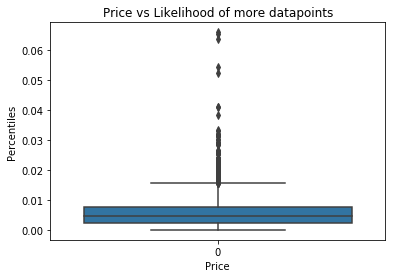

In [59]:
#Extracting price feature and plotting Box plot
plot_Box_plot(X_test_price[fp_indices])

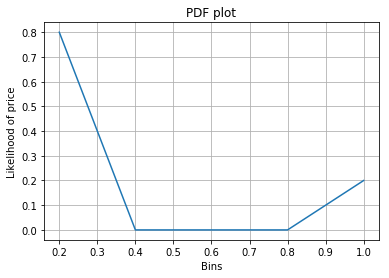

In [60]:
#Extracting teacher_number_of_previously_posted_projects feature and plotting PDF
plot_PDF(np.array(X_test_tchr_prfx[fp_indices].toarray()))

In [61]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]


x.add_row(["TFIDF", 'Decision Tree', clf_set1.best_params_, test_auc_set2])
x.add_row(["W2V", 'Decision Tree', clf_set2.best_params_, test_auc_set1])
x.add_row(["TFIDF", 'Logistic Regression', grid_search.best_params_, LR_test_auc_set1])
print(x)

+------------+---------------------+---------------------------------------------+--------------------+
| Vectorizer |        Model        |               Hyper parameter               |        AUC         |
+------------+---------------------+---------------------------------------------+--------------------+
|   TFIDF    |    Decision Tree    | {'max_depth': 10, 'min_samples_split': 500} | 0.6270552081789021 |
|    W2V     |    Decision Tree    |  {'max_depth': 5, 'min_samples_split': 100} | 0.6382660714947075 |
|   TFIDF    | Logistic Regression |                 {'C': 0.001}                | 0.5750185809151741 |
+------------+---------------------+---------------------------------------------+--------------------+
